<a href="https://colab.research.google.com/github/addo561/learning-pytorch/blob/main/optimizers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import sys
print(sys.version)

3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]


In [61]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import tqdm

In [62]:
torch.manual_seed(1234)
random.seed(1234)
np.random.seed(1234)

In [63]:
mean = 0.13066048920154572
std = 0.30810779333114624

train_transforms = transforms.Compose([
                            transforms.RandomRotation(5),
                            transforms.RandomCrop(28, padding = 2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean = [mean], std = [std])])

train_data = datasets.MNIST(root = '.data',
                            train = True,
                            download = True,
                            transform = train_transforms)

In [64]:
batch_size = 128
train_dataloader = data.DataLoader(train_data,
                                   shuffle=True,
                                   batch_size =  batch_size)

In [65]:
img,label = next(iter(train_dataloader))

In [66]:
img[0].shape

torch.Size([1, 28, 28])

In [67]:
label[0]

tensor(6)

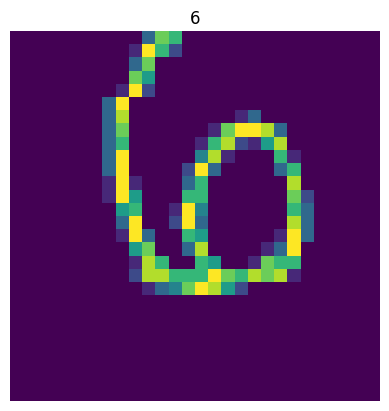

In [68]:
plt.imshow(img[0].permute(1,2,0).squeeze(0))
plt.title(label[0].item())
plt.axis('off')
plt.show()

In [69]:
class MLP(nn.Module):
  def __init__(self,input_dim,output_dim,hidden_dim):
    super().__init__()
    self.l1 = nn.Linear(input_dim,hidden_dim)
    self.l2 = nn.Linear(hidden_dim,hidden_dim)
    self.l3 = nn.Linear(hidden_dim,output_dim)
    self.init_params()

  def init_params(self):
    for n,p in self.named_parameters():
      if 'weight' in n:
        nn.init.kaiming_normal_(p,nonlinearity='relu')
      elif 'bias' in n:
        nn.init.constant_(p,0)

  def forward(self,x):
    batch_size,*_ = x.shape
    x = x.view(batch_size,-1)
    x = F.relu(self.l1(x))
    x = F.relu(self.l2(x))
    x = self.l3(x)
    return x


In [70]:
input_dim = 28 * 28
hid_dim = 256
output_dim = 10

model = MLP(input_dim, output_dim, hid_dim)

In [71]:
model

MLP(
  (l1): Linear(in_features=784, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=256, bias=True)
  (l3): Linear(in_features=256, out_features=10, bias=True)
)

In [72]:
criterion = nn.CrossEntropyLoss()

In [73]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)
device

device(type='cpu')

In [74]:
def train(train_dataloader,optimizer,model,device,criterion,epoches):
  losses = []

  model.init_params()
  for epoch in range(epoches):
    epoch_loss = []
    for img,label in tqdm.tqdm(train_dataloader):
      img,label = img.to(device),label.to(device)
      preds = model(img)
      loss = criterion(preds,label)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      epoch_loss.append(loss.item())
    losses.extend(epoch_loss)
  return  losses




In [75]:
def plot_loss(loss, title=None, ymin=0, ymax=None, figsize=(15,5)):
    """Plots the loss from a single experiment."""

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(loss)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Steps')
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.grid()

In [76]:
def plot_losses(losses, labels, title=None, ymin=0, ymax=None, figsize=(15,5)):
    """Plots the losses from multiple experiments."""

    fig, ax = plt.subplots(figsize=figsize)
    for loss, label in zip(losses, labels):
        ax.plot(loss, label=label)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Steps')
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.grid()
    ax.legend(loc='upper right')

In [77]:
class sgd:
  def __init__(self,model_params,lr=1e-3):
    self.model_params = list(model_params)
    self.lr = lr

  def zero_grad(self):
    for param in self.model_params:
      param.grad = None

  @torch.no_grad()
  def step(self):
    for param in self.model_params:
      param.sub_(self.lr*param.grad)

In [78]:

optimizer = sgd(model.parameters())

In [79]:
optimizer

In [80]:
sgd_loss = train(train_dataloader,optimizer,model,device,criterion,5)

100%|██████████| 469/469 [00:28<00:00, 16.59it/s]


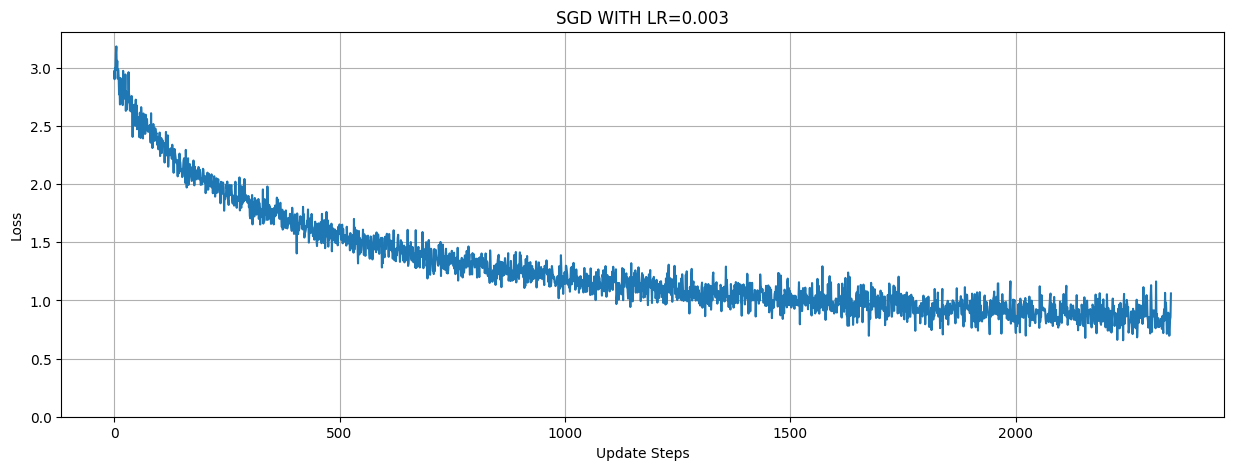

In [81]:
plot_loss(sgd_loss,'SGD WITH LR=0.003')

In [82]:
sgd_loss[:2]

[2.9701645374298096, 2.9037394523620605]

In [83]:
class sgd_momentum:
  def __init__(self,model_params,lr=1e-3,momentum=0.9):
    self.model_params = list(model_params)
    self.lr = lr
    self.momentum = momentum
    self.v = [torch.zeros_like(p) for p in self.model_params]
  def zero_grad(self):
    for param in self.model_params:
      param.grad = None
  @torch.no_grad()
  def step(self):
    for param,v in zip(self.model_params,self.v):
      v.mul_(self.momentum).add_(param.grad)
      param.sub_(self.lr*v)

In [84]:
from copy import deepcopy
model_m = deepcopy(model)
optimizer_sgd_momentum = sgd_momentum(model_m.parameters())

In [85]:
optimizer_sgd_momentum

In [86]:
sgd_loss_m = train(train_dataloader,optimizer_sgd_momentum,model_m,device,criterion,5)

100%|██████████| 469/469 [00:28<00:00, 16.35it/s]


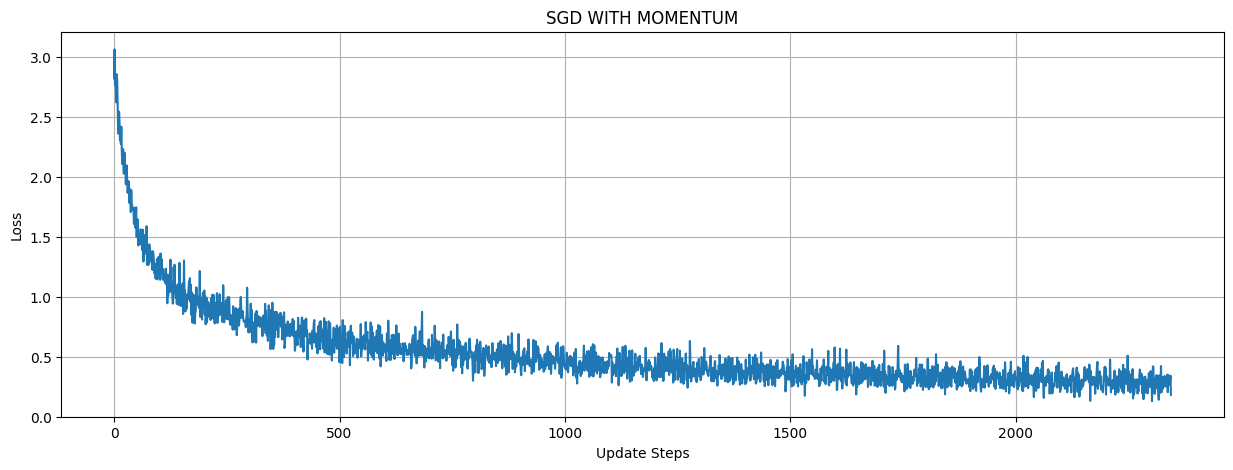

In [87]:
plot_loss(sgd_loss_m,'SGD WITH MOMENTUM')

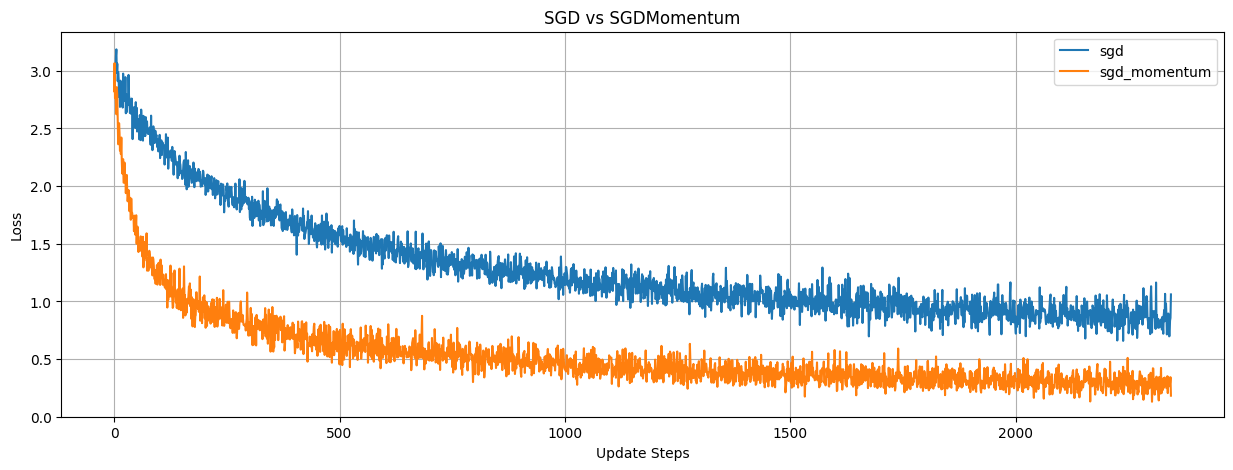

In [88]:
losses = [sgd_loss, sgd_loss_m]
labels = ['sgd', 'sgd_momentum']

plot_losses(losses, labels, 'SGD vs SGDMomentum')

In [89]:
class adagrad:
  def __init__(self,model_params,lr=1e-2,init_acc_sqr_grad=0,ep=1e-10):
    self.model_params = list(model_params)
    self.lr = lr
    self.acc_sqr_grad = [torch.full_like(p,init_acc_sqr_grad) for p in self.model_params]
    self.ep = ep
  def zero_grad(self):
    for param  in  self.model_params:
      param.grad = None
  @torch.no_grad()
  def step(self):
    for param,acc_sqr_grad in zip(self.model_params,self.acc_sqr_grad):
      acc_sqr_grad.add_(param.grad**2)
      std = acc_sqr_grad.sqrt().add(self.ep)
      param.sub_((self.lr/std )* param.grad)


In [90]:
model_adagrad = deepcopy(model)
optimizer_adagrad = adagrad(model_adagrad.parameters())

In [91]:
adagrad_loss = train(train_dataloader,optimizer_adagrad,model_adagrad,device,criterion,5)

100%|██████████| 469/469 [00:29<00:00, 16.17it/s]


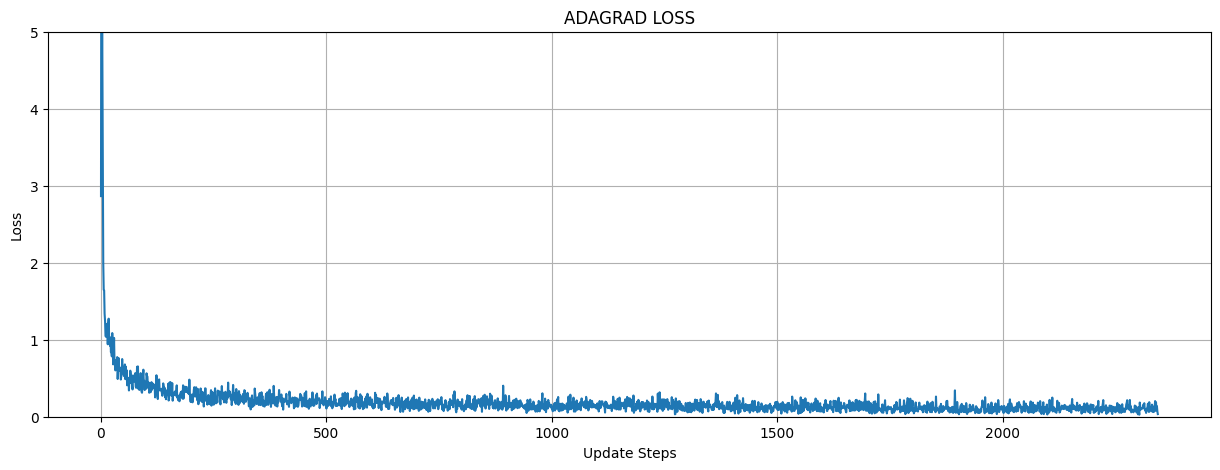

In [127]:
plot_loss(adagrad_loss,'ADAGRAD LOSS',ymax=5)

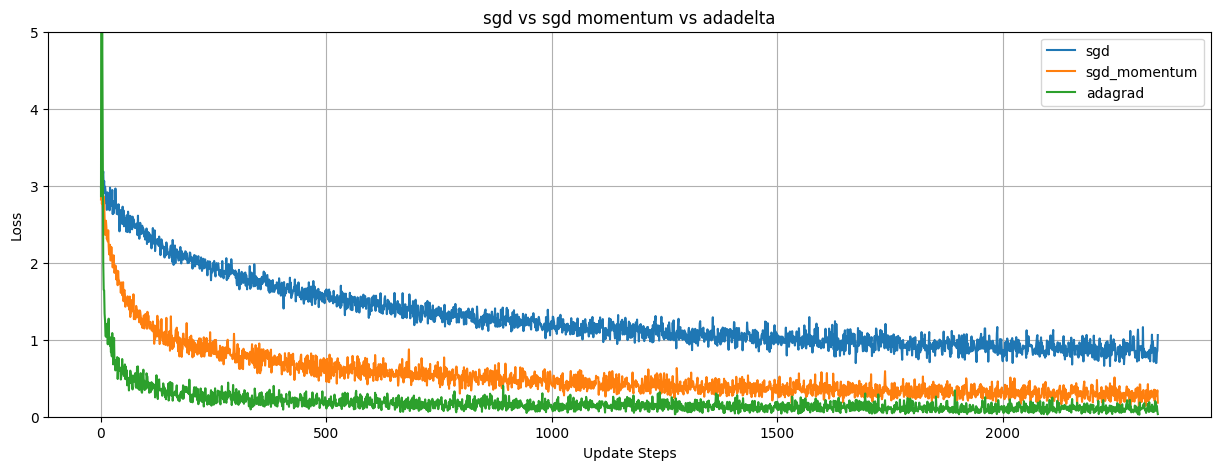

In [111]:
labels = ['sgd' ,'sgd_momentum' ,'adagrad']
plot_losses([sgd_loss, sgd_loss_m,adagrad_loss],labels,'sgd vs sgd momentum vs adadelta',ymax=5)

In [94]:
adagrad_losses = {0:adagrad_loss}

In [95]:
optimizer_adagrad_1 = adagrad(model_adagrad.parameters(),init_acc_sqr_grad=1)

In [96]:
adagrad_losses[1] = train(train_dataloader,optimizer=optimizer_adagrad_1,model=model_adagrad,device=device,criterion=criterion,epoches=5)

100%|██████████| 469/469 [00:29<00:00, 15.88it/s]


In [97]:
optimizer_adagrad_2 = adagrad(model_adagrad.parameters(),init_acc_sqr_grad=0.1)
adagrad_losses[0.1]  = train(train_dataloader,optimizer_adagrad_2,model_adagrad,device,criterion,5)

100%|██████████| 469/469 [00:29<00:00, 15.78it/s]


In [98]:
optimizer_adagrad_3 = adagrad(model_adagrad.parameters(),init_acc_sqr_grad=0.01)
adagrad_losses[0.01]  = train(train_dataloader,optimizer_adagrad_3,model_adagrad,device,criterion,5)

100%|██████████| 469/469 [00:28<00:00, 16.45it/s]


In [99]:
optimizer_adagrad_4 = adagrad(model_adagrad.parameters(),init_acc_sqr_grad=0.001)
adagrad_losses[0.001]  = train(train_dataloader,optimizer_adagrad_4,model_adagrad,device,criterion,5)

100%|██████████| 469/469 [00:29<00:00, 16.01it/s]


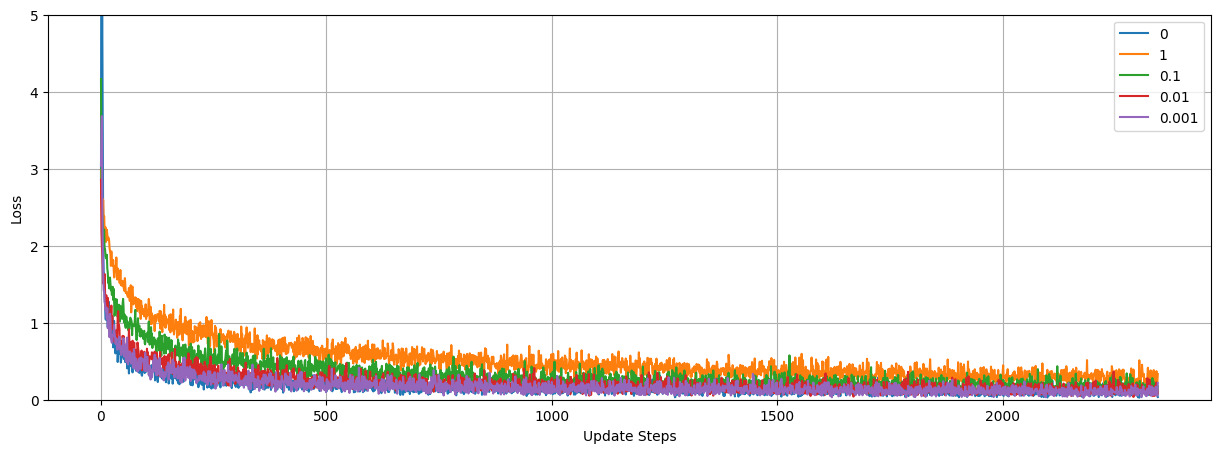

In [125]:
labels,losses = zip(*adagrad_losses.items())
plot_losses(losses,labels,ymax=5)

In [136]:
class Adadelta:
    def __init__(self, model_params, lr=1.0, rho=0.9, eps=1e-6):
        self.model_params = list(model_params)
        self.lr = lr
        self.rho = rho
        self.eps = eps
        self.avg_sqr_grads = [torch.zeros_like(p) for p in self.model_params]
        self.avg_sqr_deltas = [torch.zeros_like(p) for p in self.model_params]

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, avg_sqr_grad, avg_sqr_delta in zip(self.model_params, \
                                                      self.avg_sqr_grads, \
                                                      self.avg_sqr_deltas):
            avg_sqr_grad.mul_(self.rho).add_(param.grad * param.grad * (1 - self.rho))
            std = avg_sqr_grad.add(self.eps).sqrt()
            delta = avg_sqr_delta.add(self.eps).sqrt().div(std).mul(param.grad)
            param.sub_(self.lr * delta)
            avg_sqr_delta.mul_(self.rho).add_(delta * delta * (1 - self.rho))

In [137]:
model_adadelta = deepcopy(model)
optimizer_adadelta = Adadelta(model_adadelta.parameters())

In [138]:
adadelta_loss = train(train_dataloader,optimizer_adadelta,model_adadelta,device,criterion,5)

100%|██████████| 469/469 [00:29<00:00, 16.10it/s]


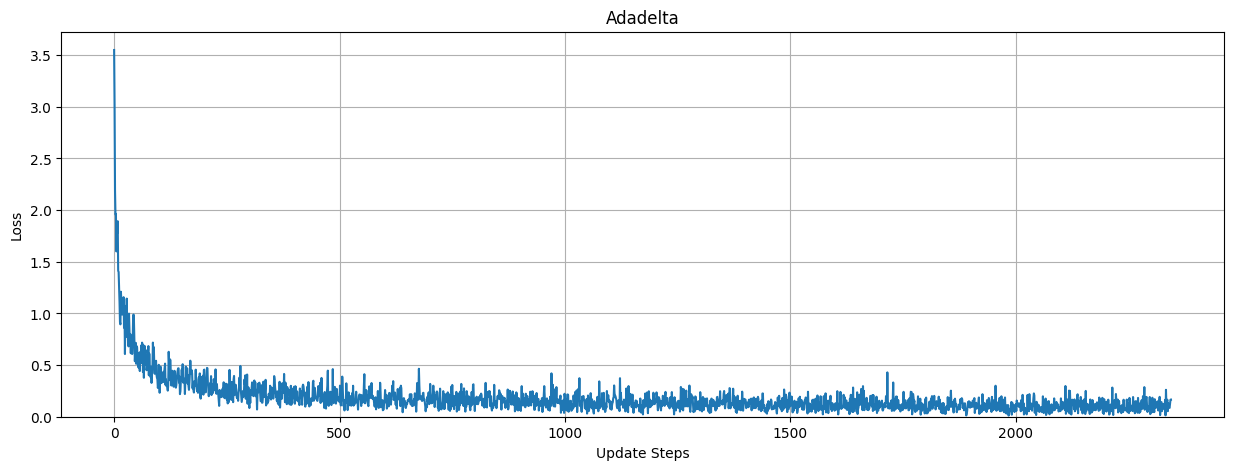

In [139]:
plot_loss(adadelta_loss,'Adadelta')

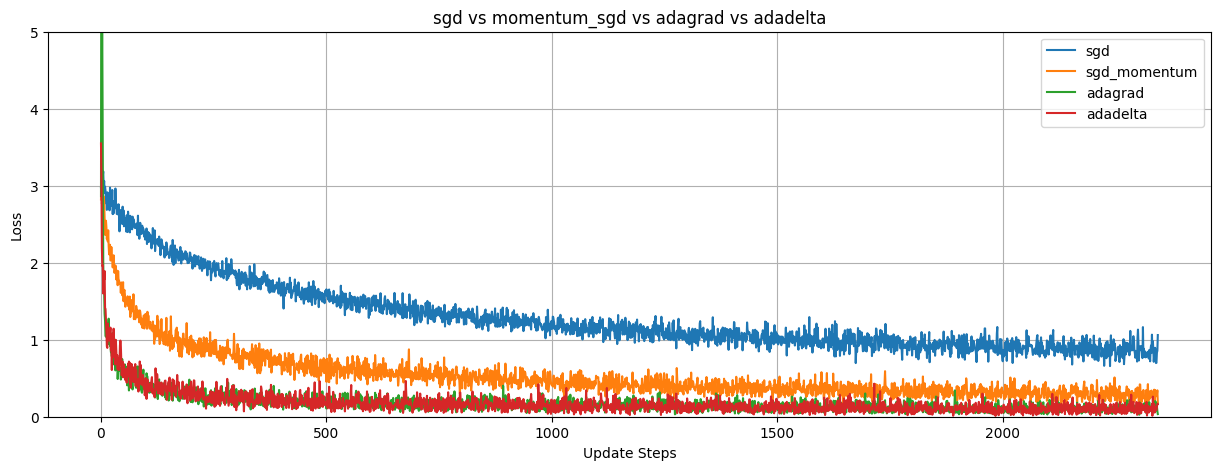

In [140]:
labels = ['sgd' ,'sgd_momentum' ,'adagrad','adadelta']
plot_losses([sgd_loss,sgd_loss_m,adagrad_loss,adadelta_loss],labels,'sgd vs momentum_sgd vs adagrad vs adadelta',ymax=5)